# Beamline Optimization - Initialization
This notebook performs sequential optimization of the UH beamline using custom modules and beam parameters.

Help for associated beamline element indexing: image.png

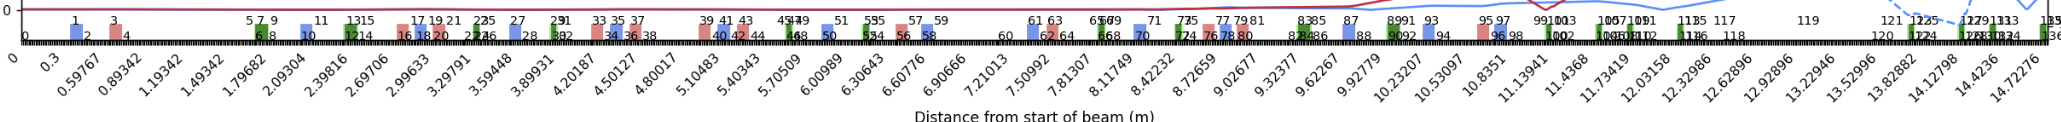

In [1]:
# Import Python modules
%matplotlib ipympl
import sys
import time
from pathlib import Path
import numpy as np
import pandas as pd
import sympy as sp
import sympy.plotting as plot

# Import Beam Dynamics modules
from ebeam import beam
from beamline import lattice, beamline
from schematic import draw_beamline
from excelElements import ExcelElements
from beamOptimizer import beamOptimizer
from AlgebraicOptimization import AlgebraicOpti

In [2]:
# Initial Beam Parameters
Energy = 40  # MeV
f = 2856e6  # Hz
bunch_spread = 2  # ps
energy_std_percent = 0.5  # 0.3 % Energy spread from M. Hadmack Rev. Sci. Instrum. 84, 063302 (2013); doi: 10.1063/1.4809938 
h = 5e9  # 1/s

epsilon_n = 8  # pi.mm.mrad
x_std = 0.8  # mm
y_std = 0.8  # mm
nb_particles = 1000

relat = lattice(1,fringeType=None)
relat.setE(E=Energy)
norm = relat.gamma * relat.beta
epsilon = epsilon_n / norm
print(relat.gamma)
print(relat.beta)
print(epsilon)
x_prime_std = epsilon / x_std
y_prime_std = epsilon / y_std

tof_std = bunch_spread * 1e-9 * f
gen_tof = np.random.normal(0, tof_std, size=(nb_particles, 1))
energy_std = energy_std_percent * 10

ebeam = beam()
beam_dist = ebeam.gen_6d_gaussian(0, [x_std,x_prime_std,y_std,y_prime_std,tof_std,energy_std], nb_particles)
tof_dist = beam_dist[:,4] / f
beam_dist[:,5] += h * tof_dist


# MkV FEL Undulator matching
K = 1.2
lambda_u = 2.3  # Undulator period in cm

beta_ym = relat.gamma / (K * (2 * np.pi / (lambda_u * 1e-2)))
print(beta_ym)
y_std_m = np.sqrt(epsilon * 1e-6 * beta_ym)
print(y_std_m)
y_prime_std_m = np.sqrt(epsilon * 1e-6 / beta_ym) # Beam at waist so Gamma(z_w) = 1 / Beta(z_w)
print(y_prime_std_m)

79.2794183839214
0.9999204452035254
0.10091694227956337
0.2418394669906551
0.00015622323620773033
0.0006459790792284825


In [3]:
# Load Beamline from Excel
path = Path(r"C:\Users\NielsB\cernbox\Hawaii University\Beam dynamics\UH_FELxBeamDyn")
file_path = path / 'Beamline_elements.xlsx'
excel = ExcelElements(file_path)
df = excel.get_dataframe()
beamlineUH = excel.create_beamline()
schem = draw_beamline()
line_UH = relat.changeBeamType("electron", Energy, beamlineUH)

# Optimizer and beamline truncation
print('Number of elements in beamline: ' + str(len(line_UH)))
segments = 138
line = line_UH[:segments]
opti = beamOptimizer(line, beam_dist)

Number of elements in beamline: 138


In [4]:
# Optimization - First Quadrupole Doublet

variables = {
    1: ["I", "current", lambda num:num],
    3: ["I2", "current", lambda num:num],
}
startPoint = {
    "I": {"bounds": (0,10), "start": 1},
    "I2": {"bounds": (0, 10), "start": 1},
}

objectives = {8: [{"measure": ["x", "alpha"], "goal": 0, "weight":1},
                  {"measure": ["x", "beta"], "goal": 0.1, "weight":0.0}],
              9: [{"measure": ["y", "alpha"], "goal": 0, "weight":1},
                  {"measure": ["y", "beta"], "goal": 0.1, "weight":0.5}]}            

result = opti.calc("Nelder-Mead", variables, startPoint, objectives, plotBeam=False, printResults=True, plotProgress=False)

# old values
# line[1].current = 0.9989681933
# line[3].current = 1.044851479


x variables:
indice 1 new current value: 0.8343286589530641
indice 3 new current value: 1.0516912449156959

y objectives:
indice 8: x alpha value of -0.0007597561582758788
indice 8: x beta value of 0.9848058441635344
indice 9: y alpha value of -0.0005227823740065988
indice 9: y beta value of 0.13365916314669204
Final difference: 0.00014183004067460647

Total time: 413.7134558 s
Total iterations: 65



In [5]:
# Optimization - First Chromacity Quad

variables = {10: ["I", "current", lambda num:num]}
startPoint = {"I": {"bounds": (0,10), "start": 1}}
objectives = {15: [{"measure": ["x", "dispersion"], "goal": 0, "weight": 1}]}
result = opti.calc("Nelder-Mead", variables, startPoint, objectives, plotBeam=False, printResults=True, plotProgress=False)


x variables:
indice 10 new current value: 4.366992187500007

y objectives:
indice 15: x disper value of 4.976739660469802e-07
Final difference: 1.822361513512593e-14

Total time: 235.2167372 s
Total iterations: 40



In [6]:
# Optimization - Quadrupole Triplet

truncated_line = line[:17]
# Add half a quad
#truncated_line.append(qpfLattice(current = 3.816604, length=0.0889/2))

variables = {
    16: ["I", "current", lambda num:num],
    18: ["I2", "current", lambda num:num],
    20: ["I3", "current", lambda num:num],
}
startPoint = {
    "I": {"bounds": (0,10), "start": 2},
    "I2": {"bounds": (0, 10), "start": 5},
    "I3": {"bounds": (0, 10), "start": 3},
}

objectives = {25: [{"measure": ["x", "alpha"], "goal": 0, "weight":1},
                  {"measure": ["x", "beta"], "goal": 0.1, "weight":0.5}],
              26: [{"measure": ["y", "alpha"], "goal": 0, "weight":1},
                  {"measure": ["y", "beta"], "goal": 0.1, "weight":0.5}]}     

result = opti.calc("Nelder-Mead", variables, startPoint, objectives, plotBeam=False, printResults=True, plotProgress=False)

# old values
# line[16].current = 2.4
# line[18].current = 5.108214683
# line[20].current = 3.142089844


x variables:
indice 16 new current value: 2.213580098092919
indice 18 new current value: 4.932779104555563
indice 20 new current value: 3.4384837937107857

y objectives:
indice 25: x alpha value of -7.43467625036137e-05
indice 25: x beta value of 0.009912508395595538
indice 26: y alpha value of -0.0005153859338615028
indice 26: y beta value of 0.011416379180629323
Final difference: 0.001995378787533665

Total time: 616.3146479999999 s
Total iterations: 105



In [7]:
# Optimization - Second Chromacity Quad

variables = {27: ["I", "current", lambda num:num]}
startPoint = {"I": {"bounds": (0,10), "start": 1}}
objectives = {32: [{"measure": ["x", "dispersion"], "goal": 0, "weight": 1}]}
result = opti.calc("Nelder-Mead", variables, startPoint, objectives, plotBeam=False, printResults=True, plotProgress=False)


x variables:
indice 27 new current value: 4.808789062500008

y objectives:
indice 32: x disper value of 1.1509520161950997e-06
Final difference: 1.0469737816285674e-14

Total time: 232.9627805 s
Total iterations: 40



In [8]:
# Optimization - Double Quadrupole Triplet

variables = {
    37: ["I", "current", lambda num:num],
    35: ["I2", "current", lambda num:num],
    33: ["I3", "current", lambda num:num],
}
startPoint = {
    "I": {"bounds": (0,10), "start": 2},
    "I2": {"bounds": (0, 10), "start": 2},
    "I3": {"bounds": (0, 10), "start": 2},
}
objectives = {
    37: [
        {"measure": ["x", "alpha"], "goal": 0, "weight": 1},
        {"measure": ["y", "alpha"], "goal": 0, "weight": 1},
        {"measure": ["x", "envelope"], "goal": 2.0, "weight": 1},
        {"measure": ["y", "envelope"], "goal": 2.0, "weight": 1}
    ]
}
result = opti.calc("Nelder-Mead", variables, startPoint, objectives, plotBeam=False, printResults=True, plotProgress=False)

line[43].current = line[33].current
line[41].current = line[35].current
line[39].current = line[37].current


x variables:
indice 37 new current value: 0.4145051328641406
indice 35 new current value: 2.7592266404815105
indice 33 new current value: 2.6787558321526426

y objectives:
indice 37: x alpha value of -0.0029200227749751092
indice 37: y alpha value of -0.0025064932248442117
indice 37: x envelope value of 1.7246296836475925
indice 37: y envelope value of 1.7801360813917722
Final difference: 0.031045940718770745

Total time: 682.2891887000001 s
Total iterations: 116



In [9]:
# Optimization - Third Chromacity Quad

variables = {50: ["I", "current", lambda num:num]}
startPoint = {"I": {"bounds": (0,10), "start": 1}}
objectives = {55: [{"measure": ["x", "dispersion"], "goal": 0, "weight": 1}]}
result = opti.calc("Nelder-Mead", variables, startPoint, objectives, plotBeam=False, printResults=True, plotProgress=False)



x variables:
indice 50 new current value: 4.733593750000008

y objectives:
indice 55: x disper value of 1.129507135471058e-06
Final difference: 1.3231826004437528e-13

Total time: 234.10838310000008 s
Total iterations: 40



In [10]:
# Optimization - Quadrupole Doublet and Interaction Point (z = 7.11 m, end of element index = 59)

variables = {
    56: ["I", "current", lambda num:num],
    58: ["I2", "current", lambda num:num],
}
startPoint = {
    "I": {"bounds": (0,10), "start": 2},
    "I2": {"bounds": (0, 10), "start": 2},
}

objectives = {
    59: [
        {"measure": ["x", "envelope"], "goal": 0.0, "weight": 1},
        {"measure": ["y", "envelope"], "goal": 0.0, "weight": 1}
    ]
}

result = opti.calc("Nelder-Mead", variables, startPoint, objectives, plotBeam=False, printResults=True, plotProgress=False)


x variables:
indice 56 new current value: 3.122386276416007
indice 58 new current value: 3.3188798930238526

y objectives:
indice 59: x envelope value of 0.019364956454773246
indice 59: y envelope value of 0.05033081613016781
Final difference: 0.001454096295412012

Total time: 493.60629080000035 s
Total iterations: 83



In [11]:
# Optimization - Quadrupole Doublet

variables = {
    61: ["I", "current", lambda num:num],
    63: ["I2", "current", lambda num:num],
}
startPoint = {
    "I": {"bounds": (0,10), "start": 2},
    "I2": {"bounds": (0, 10), "start": 2},
}

objectives = {
    68: [{"measure": ["x", "alpha"], "goal": 0, "weight": 1},
        {"measure": ["x", "beta"], "goal": 0.1, "weight": 0.5}],
    69: [{"measure": ["y", "alpha"], "goal": 0, "weight": 1},
         {"measure": ["y", "beta"], "goal": 0.1, "weight": 0.5}]
}

result = opti.calc("Nelder-Mead", variables, startPoint, objectives, plotBeam=False, printResults=True, plotProgress=False)



x variables:
indice 61 new current value: 5.178163930935915
indice 63 new current value: 4.045387326378372

y objectives:
indice 68: x alpha value of -0.000702632930938864
indice 68: x beta value of 0.04488639855122088
indice 69: y alpha value of -0.00020846410040734225
indice 69: y beta value of 0.013577416950070186
Final difference: 0.0013134307782888103

Total time: 661.6767292999998 s
Total iterations: 102



In [12]:
# Optimization - Fourth Chromacity Quad

variables = {70: ["I", "current", lambda num:num]}
startPoint = {"I": {"bounds": (0,10), "start": 1}}
objectives = {75: [{"measure": ["x", "dispersion"], "goal": 0, "weight": 1}]}
result = opti.calc("Nelder-Mead", variables, startPoint, objectives, plotBeam=False, printResults=True, plotProgress=False)


x variables:
indice 70 new current value: 4.608886718750007

y objectives:
indice 75: x disper value of -1.932349109844272e-07
Final difference: 3.733973082315951e-14

Total time: 265.52249919999986 s
Total iterations: 40



In [13]:
# Optimization - Quadrupole Triplet

variables = {
    76: ["I", "current", lambda num:num],
    78: ["I2", "current", lambda num:num],
    80: ["I3", "current", lambda num:num],
}
startPoint = {
    "I": {"bounds": (0,10), "start": 2},
    "I2": {"bounds": (0, 10), "start": 2},
    "I3": {"bounds": (0, 10), "start": 2},
}

objectives = {
    85: [{"measure": ["x", "alpha"], "goal": 0, "weight": 1},
        {"measure": ["x", "beta"], "goal": 0.1, "weight": 0.5}],
    86: [{"measure": ["y", "alpha"], "goal": 0, "weight": 1},
         {"measure": ["y", "beta"], "goal": 0.1, "weight": 0.5}]
}

result = opti.calc("Nelder-Mead", variables, startPoint, objectives, plotBeam=False, printResults=True, plotProgress=False)


x variables:
indice 76 new current value: 3.93921940870355
indice 78 new current value: 4.084724100577855
indice 80 new current value: 0.0

y objectives:
indice 85: x alpha value of 6.95647477979758e-05
indice 85: x beta value of 0.07719244856601501
indice 86: y alpha value of 0.0003124875387733653
indice 86: y beta value of 0.08388458711788188
Final difference: 9.751198877588243e-05

Total time: 924.0174053999995 s
Total iterations: 144



In [14]:
# Optimization - Fifth Chromacity Quad

variables = {87: ["I", "current", lambda num:num]}
startPoint = {"I": {"bounds": (0,10), "start": 1}}
objectives = {92: [{"measure": ["x", "dispersion"], "goal": 0, "weight": 1}]}
result = opti.calc("Nelder-Mead", variables, startPoint, objectives, plotBeam=False, printResults=True, plotProgress=False)


x variables:
indice 87 new current value: 3.870214843750006

y objectives:
indice 92: x disper value of 1.6775061515641282e-07
Final difference: 2.814026888535492e-14

Total time: 255.78714839999975 s
Total iterations: 40



In [15]:
# Optimization - Quadrupole Triplet and MkIII undulator start (z = 12.389 m , end of element index = 117)

variables = {
    93: ["I", "current", lambda num:num],
    95: ["I2", "current", lambda num:num],
    97: ["I3", "current", lambda num:num],
}
startPoint = {
    "I": {"bounds": (0,10), "start": 2},
    "I2": {"bounds": (0, 10), "start": 2},
    "I3": {"bounds": (0, 10), "start": 2},
}
objectives = {
    117: [
        {"measure": ["x", "alpha"], "goal": 0, "weight": 1},
        {"measure": ["y", "alpha"], "goal": 0, "weight": 1},
        {"measure": ["x", "beta"], "goal": beta_ym, "weight": 1},
        {"measure": ["y", "beta"], "goal": beta_ym, "weight": 1}
    ]
}
result = opti.calc("Nelder-Mead", variables, startPoint, objectives, plotBeam=False, printResults=True, plotProgress=False)


#indice 93 new current value: 2.1275944045328767
#indice 95 new current value: 1.543397467601471
#indice 97 new current value: 0.3798657737076452


x variables:
indice 93 new current value: 0.3863848676348004
indice 95 new current value: 3.398712419636314
indice 97 new current value: 2.5490819710531247

y objectives:
indice 117: x alpha value of 0.01889444118987029
indice 117: y alpha value of 0.0004027760319211725
indice 117: x beta value of 0.22516113035526586
indice 117: y beta value of 0.05037586805576366
Final difference: 0.009323409461357613

Total time: 2284.9253429 s
Total iterations: 353



Simulating Beamline:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1514/1550 [00:30<00:00]


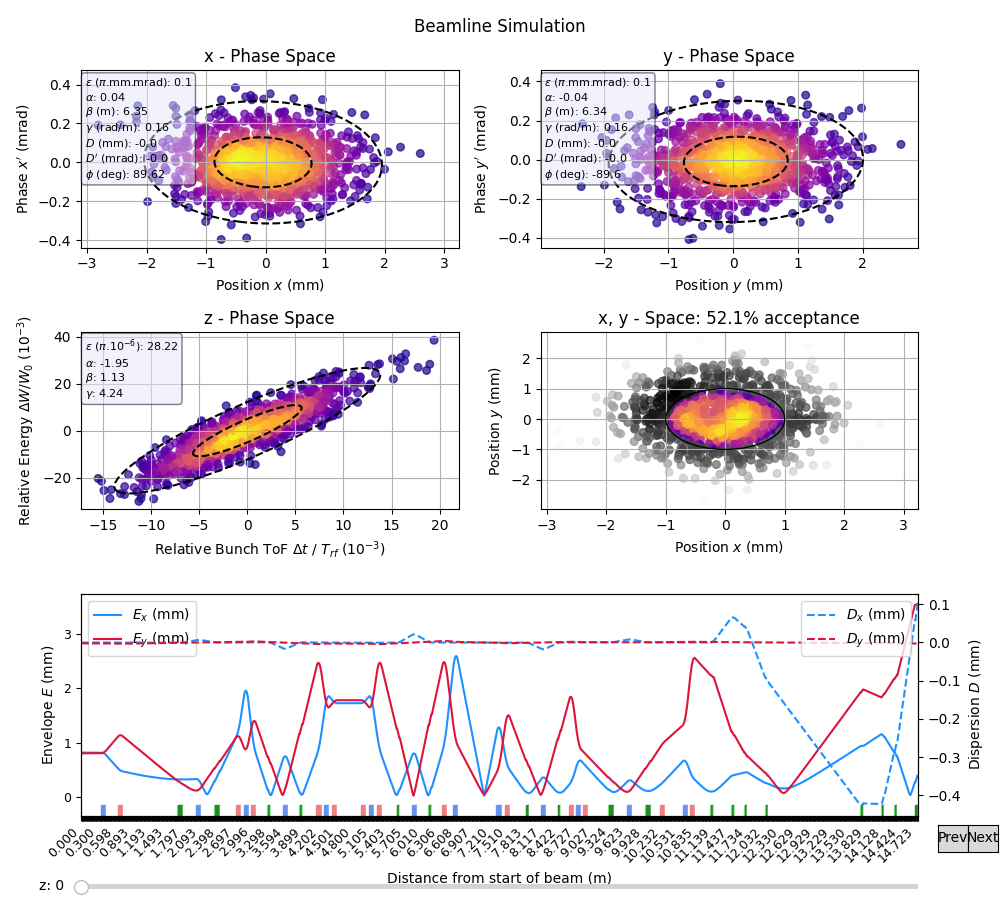

$\epsilon$ ($\pi$.mm.mrad)  \
x  [0.1047918498325419, 0.1047918498325419, 0.104...   
y  [0.10142013718329435, 0.10142013718329433, 0.1...   
z  [28.22159518923279, 28.22159518923279, 28.2215...   

                                            $\alpha$  \
x  [0.04140952395358027, 0.03983310173397128, 0.0...   
y  [-0.04364387399014322, -0.045224868522625014, ...   
z  [-1.9454269463697647, -1.9453635012173798, -1....   

                                         $\beta$ (m)  \
x  [6.354355680945303, 6.353543254688429, 6.35276...   
y  [6.337180598367403, 6.33806928579253, 6.338989...   
z  [1.128956757514375, 1.1288985123130342, 1.1288...   

                                    $\gamma$ (rad/m)  \
x  [0.15764222196089633, 0.15764222196089633, 0.1...   
y  [0.1580994532481811, 0.15809945324818112, 0.15...   
z  [4.238148159187278, 4.238148159187278, 4.23814...   

                                            $D$ (mm)  \
x  [-0.00016352286769074828, -0.00016752037168485...   
y  [-0.002317014235043655, -0.002317577568845738,...   
z  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                 $D^{\prime}$ (mrad)  \
x  [-0.00039975039941071374, -0.00039975039941071...   
y  [-5.6333380208458424e-05, -5.6333380208458424e...   
z  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                        $\phi$ (deg)  
x  [89.6171438749742, 89.63166893040251, 89.64619...  
y  [-89.59533733131228, -89.58074081774737, -89.5...  
z  [-25.685778992848086, -25.68506162655775, -25....

In [16]:
# Display Optimized Beamline

%matplotlib ipympl
acceptance = {"shape":'circle', "radius":1, "origin":[0,0]}
schem.plotBeamPositionTransform(beam_dist, line, 0.01, plot=True, showIndice=False, 
                                defineLim=False, matchScaling=False, shape=acceptance, scatter=True)

